Remember, the raw data includes ordinary CitiBike trips but excludes an important wrinkle: rebalancing trips. These, too, need to be incorporated.

While doing the citibike weekly data generation I got around this problem by leaving the full dataset compilation step until I got to the geocoding. This was necessary because calculating full start and end times for a rebalanced trip is easiest to do by querying the Google API and getting back a trip estimate time.

However for the expanded scope of the viz envisioned since, this is too limiting. I need to actually be able to generate a single unified file *before* I start intensively processing trips and depositing them into my data store.

So what I decided I will do is check the trips to get rebalancing trips, as before, but this time query the Google API ahead of time, run those trips through their API, get the estimated trip time, discard the rest of the response (!), and generate and embed a new trip in the dataset using that trip time.

This is a little wasteful of resources, but strikes me as being simply too necessary to ignore. If I were to defer doing this until the final data processing and storage step, I would have to somehow account for those additional trips in my rate-limit monitoring, and somehow know how to encode them (hash them?). Doing it beforehand may waste a day's worth of API queries, but it will also make actually deaing with stuffing the data into the storage layer much easier.

An important caveat to consider is when a bike recieves a rebalancing trip, and that rebalancing trip is its end of day. For instance, suppose the raw data says that bike 112233 was ridden to station B on June 22, but then on June 23 it was ridden from station C. Then in between those two start and end times there was a rebalancing trip. But wait a minute, what if our standard estimation technique&mdash;interpolating midway&mdash;gives us a transfer time at 12:20-1:00 PM early June 23, after our visualization period has ended? What then?

As you can see, considering this limiting case is solvable by broadcasting against the bike trips remaining for the month, but I given the low volume of rebalancing trips in the first place I decided that honestly it's not worth the additional complexity. So the final visualization will have that one important caveat: bike transfers which occur during June 22nd but which occur after any rides on that day are not accounted for.

I will also calculate a unique id&mdash;this is useful for rate-limiting the data deposit script.

In [1]:
import pandas as pd
import os
import sys
from tqdm import tqdm
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import citibike_trips

In [2]:
raw_data = pd.read_csv("../data/part_2/citibike_trips_on_june_22_2016.csv", index_col=0)

In [3]:
raw_data['starttime'].map(lambda time: time[:9]).value_counts()

6/22/2016    55749
Name: starttime, dtype: int64

In [4]:
bike_ids = set(raw_data['bikeid'].values)
bike_trip_sets = [raw_data[raw_data['bikeid'] == bike_id].sort_values(by='starttime') for bike_id in bike_ids]

Here's an example of a tripset which included a needs-to-be-generated rebalanced trip.

In [5]:
[bike_trip_set for bike_trip_set in bike_trip_sets if bike_trip_set['bikeid'].iloc[0] == 15636][0]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
1009289,566,6/22/2016 07:40:55,6/22/2016 07:50:21,3230,Penn Station Valet,40.751284,-73.996924,153,E 40 St & 5 Ave,40.752062,-73.981632,15636,Subscriber,1976.0,1
1009990,716,6/22/2016 07:51:39,6/22/2016 08:03:35,153,E 40 St & 5 Ave,40.752062,-73.981632,3236,W 42 St & Dyer Ave,40.758985,-73.993800,15636,Subscriber,1959.0,1
1010891,304,6/22/2016 08:04:34,6/22/2016 08:09:39,3236,W 42 St & Dyer Ave,40.758985,-73.993800,513,W 56 St & 10 Ave,40.768254,-73.988639,15636,Subscriber,1969.0,1
1011481,861,6/22/2016 08:11:43,6/22/2016 08:26:04,513,W 56 St & 10 Ave,40.768254,-73.988639,470,W 20 St & 8 Ave,40.743453,-74.000040,15636,Subscriber,1945.0,1
1012800,1133,6/22/2016 08:27:26,6/22/2016 08:46:20,470,W 20 St & 8 Ave,40.743453,-74.000040,534,Water - Whitehall Plaza,40.702551,-74.012723,15636,Subscriber,1991.0,1
1017376,113,6/22/2016 09:16:53,6/22/2016 09:18:46,534,Water - Whitehall Plaza,40.702551,-74.012723,304,Broadway & Battery Pl,40.704633,-74.013617,15636,Subscriber,1984.0,1
1038641,531,6/22/2016 17:18:53,6/22/2016 17:27:45,2000,Front St & Washington St,40.702551,-73.989402,157,Henry St & Atlantic Ave,40.690893,-73.996123,15636,Subscriber,1976.0,1


I originally made a careless fencepost error in the following code, using `len(bike_trip_set) - 2` instead. This caused the rebalancer not to check for rebalanced trips near the end of the tripset. I only discovered this error weeks later when I implemented a highlighter in the final visualization and discovered that an alarming percentage of my tripsets did not fully connect.

In [6]:
rebalancing_trip_tuples = []
for bike_trip_set in tqdm(bike_trip_sets):
    for i in range(0, len(bike_trip_set) - 1):
        possible_rebalanced_tuple = bike_trip_set.iloc[[i, i + 1]]
        if citibike_trips.RebalancingTrip.rebalanced(possible_rebalanced_tuple):
            rebalancing_trip_tuples.append(possible_rebalanced_tuple)

100%|█████████████████████████████████████| 6497/6497 [00:22<00:00, 291.18it/s]


In [7]:
len(rebalancing_trip_tuples)

1208

The following code checks for this error. The line below should evaluate to `True`.

In [8]:
rebalancing_trip_tuple = rebalancing_trip_tuples[0]
rebalancing_trip_tuple['bikeid'].iloc[0]

14529

In [9]:
bikes_rebalanced_by_id = [rebalancing_trip_tuple['bikeid'].iloc[0] for rebalancing_trip_tuple in rebalancing_trip_tuples]

In [10]:
15636 in bikes_rebalanced_by_id

True

In [11]:
len(set(bikes_rebalanced_by_id))

1116

TEMP

*Confirm that the process actually generates the desired to-be-included rebalancing trip, using an example from the Penn Valet station.*

In [105]:
penn_rebalancing_example = [rebalancing_trip_tuple for rebalancing_trip_tuple in rebalancing_trip_tuples if rebalancing_trip_tuple['bikeid'].iloc[0] == 15636][0]
penn_rebalancing_example

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
1017376,113,6/22/2016 09:16:53,6/22/2016 09:18:46,534,Water - Whitehall Plaza,40.702551,-74.012723,304,Broadway & Battery Pl,40.704633,-74.013617,15636,Subscriber,1984.0,1
1038641,531,6/22/2016 17:18:53,6/22/2016 17:27:45,2000,Front St & Washington St,40.702551,-73.989402,157,Henry St & Atlantic Ave,40.690893,-73.996123,15636,Subscriber,1976.0,1


*Yes it does.*

*Next, confirm that executing the algorithm on this tripset creates a time-estimate result.*

In [107]:
example_estimates = []
client = citibike_trips.initialize_google_client(filename="../credentials/google_maps_api_key.json")
for rebalancing_trip_tuple in tqdm([penn_rebalancing_example]):
    start = [rebalancing_trip_tuple.iloc[0]['end station latitude'],
             rebalancing_trip_tuple.iloc[0]['end station longitude']]
    end = [rebalancing_trip_tuple.iloc[0]['start station latitude'],
           rebalancing_trip_tuple.iloc[0]['start station longitude']]
    time_estimate = citibike_trips.RebalancingTrip.get_rebalancing_trip_path_time_estimate_tuple(
        start, end, client
    )[1]
    example_estimates.append(int(time_estimate) * 60)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


In [108]:
example_estimates

[300]

*Yes it does.*

*Next, confirm that execution the full algorithm on this tripset creates a valid trip entry.*

*(the following code is copied from the execution below)*

In [109]:
from datetime import timedelta
example_deltas_subframe = []

for t, delta_df in tqdm(zip(example_estimates, [penn_rebalancing_example])):
    # The following code is ripped from the `citibike_trips` RebalancingTrip class definition.
    start_point = delta_df.iloc[0]
    end_point = delta_df.iloc[1]
    for point in [start_point, end_point]:
        for time in ['starttime', 'stoptime']:
            if isinstance(point[time], str):
                point[time] = pd.to_datetime(point[time], infer_datetime_format=True)
    midpoint_time = start_point['stoptime'] + ((end_point['starttime'] - start_point['stoptime']) / 2)
    rebalancing_start_time = midpoint_time - timedelta(seconds=t / 2)
    rebalancing_end_time = midpoint_time + timedelta(seconds=t / 2)
    if rebalancing_start_time < start_point['stoptime']:
        rebalancing_start_time = start_point['stoptime']
    if rebalancing_end_time > end_point['starttime']:
        rebalancing_end_time = end_point['starttime']
    # Explicit casts are due to mongodb limitations, see BikeTrip above.
    attributes = {
        "tripduration": int(t),
        "start station id": int(start_point['end station id']),
        "end station id": int(end_point['start station id']),
        "start station name": start_point['end station name'],
        "end station name": end_point['start station name'],
        "bikeid": int(start_point["bikeid"]),
        "usertype": "Rebalancing",
        "birth year": 0,
        "gender": 3,
        "start station latitude": start_point['end station latitude'],
        "start station longitude": start_point['end station longitude'],
        "end station latitude": end_point['start station latitude'],
        "end station longitude": end_point['start station longitude'],
        "starttime": rebalancing_start_time.strftime("%Y-%d-%m %H:%M:%S"),
        "stoptime": rebalancing_end_time.strftime("%Y-%d-%m %H:%M:%S"),
    }
    example_deltas_subframe.append(attributes)
    # TODO: Next stage of the logic.

0it [00:00, ?it/s]C:\Users\Alex\Anaconda3\envs\citibike\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
1it [00:00,  3.42it/s]


In [111]:
example_deltas_subframe[0]

{'bikeid': 15636,
 'birth year': 0,
 'end station id': 2000,
 'end station latitude': 40.702550879999997,
 'end station longitude': -73.98940236,
 'end station name': 'Front St & Washington St',
 'gender': 3,
 'start station id': 304,
 'start station latitude': 40.704633340000001,
 'start station longitude': -74.013617060000001,
 'start station name': 'Broadway & Battery Pl',
 'starttime': '2016-22-06 13:16:19',
 'stoptime': '2016-22-06 13:21:19',
 'tripduration': 300,
 'usertype': 'Rebalancing'}

*Yes it does.*

*What this proves: this trip should be included in the output on the emissions of the next few sections below. I continue validating the threading thereafter.*

TEMP

Now we may continue.

In [12]:
time_estimates = []
client = citibike_trips.initialize_google_client(filename="../credentials/google_maps_api_key.json")
for rebalancing_trip_tuple in tqdm(rebalancing_trip_tuples):
    start = [rebalancing_trip_tuple.iloc[0]['end station latitude'],
             rebalancing_trip_tuple.iloc[0]['end station longitude']]
    end = [rebalancing_trip_tuple.iloc[0]['start station latitude'],
           rebalancing_trip_tuple.iloc[0]['start station longitude']]
    time_estimate = citibike_trips.RebalancingTrip.get_rebalancing_trip_path_time_estimate_tuple(
        start, end, client
    )[1]
    time_estimates.append(int(time_estimate) * 60)

100%|██████████████████████████████████████| 1208/1208 [03:49<00:00,  5.13it/s]


TEMP

*Confirm that both `time_estimates` and `rebalancing_trip_tuples` contain the trip we are interested in.*

In [119]:
for est, tup in zip(time_estimates, rebalancing_trip_tuples):
    if tup['bikeid'].iloc[0] == 15636:
        print("Success!")
        print(est)

Success!
300


TEMP

Here are the sort times in seconds (maxes out at 33 minutes):

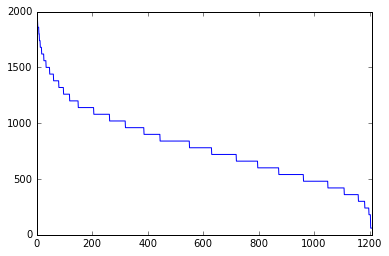

In [13]:
%matplotlib inline
pd.Series(sorted(time_estimates, reverse=True)).plot()

In [196]:
from datetime import timedelta
deltas_subframe = []

for t, delta_df in tqdm(zip(time_estimates, rebalancing_trip_tuples)):
    # The following code is ripped from the `citibike_trips` RebalancingTrip class definition.
    start_point = delta_df.iloc[0]
    end_point = delta_df.iloc[1]
    for point in [start_point, end_point]:
        for time in ['starttime', 'stoptime']:
            if isinstance(point[time], str):
                point[time] = pd.to_datetime(point[time], infer_datetime_format=True)
    midpoint_time = start_point['stoptime'] + ((end_point['starttime'] - start_point['stoptime']) / 2)
    rebalancing_start_time = midpoint_time - timedelta(seconds=t / 2)
    rebalancing_end_time = midpoint_time + timedelta(seconds=t / 2)
    if rebalancing_start_time < start_point['stoptime']:
        rebalancing_start_time = start_point['stoptime']
    if rebalancing_end_time > end_point['starttime']:
        rebalancing_end_time = end_point['starttime']
    # Explicit casts are due to mongodb limitations, see BikeTrip above.
    attributes = {
        "tripduration": int(t),
        "start station id": int(start_point['end station id']),
        "end station id": int(end_point['start station id']),
        "start station name": start_point['end station name'],
        "end station name": end_point['start station name'],
        "bikeid": int(start_point["bikeid"]),
        "usertype": "Rebalancing",
        "birth year": 0,
        "gender": 3,
        "start station latitude": start_point['end station latitude'],
        "start station longitude": start_point['end station longitude'],
        "end station latitude": end_point['start station latitude'],
        "end station longitude": end_point['start station longitude'],
#         "starttime": rebalancing_start_time.strftime("%Y-%d-%m %H:%M:%S"),
#         "stoptime": rebalancing_end_time.strftime("%Y-%d-%m %H:%M:%S"),
        "starttime": rebalancing_start_time.strftime("%m/%d/%Y %H:%M:%S").lstrip('0'),
        "stoptime": rebalancing_end_time.strftime("%m/%d/%Y %H:%M:%S").lstrip('0'),
    }
    deltas_subframe.append(attributes)
    # TODO: Next stage of the logic.

0it [00:00, ?it/s]C:\Users\Alex\Anaconda3\envs\citibike\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
1208it [06:06,  3.33it/s]


TEMP

*Confirm that the trip we are interested in is contained in `deltas_subframe`.*

In [197]:
[subframe for subframe in deltas_subframe if subframe['bikeid'] == 15636]

[{'bikeid': 15636,
  'birth year': 0,
  'end station id': 2000,
  'end station latitude': 40.702550879999997,
  'end station longitude': -73.98940236,
  'end station name': 'Front St & Washington St',
  'gender': 3,
  'start station id': 304,
  'start station latitude': 40.704633340000001,
  'start station longitude': -74.013617060000001,
  'start station name': 'Broadway & Battery Pl',
  'starttime': '6/22/2016 13:16:19',
  'stoptime': '6/22/2016 13:21:19',
  'tripduration': 300,
  'usertype': 'Rebalancing'}]

Yes it is.

*Confirm that it's in the list we generate below.*

In [198]:
True in [srs['bikeid'] == 15636 for srs in [pd.Series(df_proto) for df_proto in deltas_subframe]]

True

Yes it is.

*Confirm that it's in the concatenation of this list that is `all_rebalancing_trips`.*

In [199]:
test_all_rebalancing_trips = pd.concat([pd.Series(df_proto) for df_proto in deltas_subframe], axis=1).T

In [200]:
15636 in test_all_rebalancing_trips['bikeid'].values.astype(int)

True

Yes it is; but the typing is inconsistent.

TEMP

In [201]:
deltas_subframe[0]

{'bikeid': 14529,
 'birth year': 0,
 'end station id': 267,
 'end station latitude': 40.750977110000001,
 'end station longitude': -73.987654280000001,
 'end station name': 'Broadway & W 36 St',
 'gender': 3,
 'start station id': 546,
 'start station latitude': 40.744449209999999,
 'start station longitude': -73.983035290000004,
 'start station name': 'E 30 St & Park Ave S',
 'starttime': '6/22/2016 11:04:06',
 'stoptime': '6/22/2016 11:22:06',
 'tripduration': 1080,
 'usertype': 'Rebalancing'}

In [202]:
all_rebalancing_trips = pd.concat([pd.Series(df_proto) for df_proto in deltas_subframe], axis=1).T

In [203]:
all_rebalancing_trips

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
0,14529,0,267,40.751,-73.9877,Broadway & W 36 St,3,546,40.7444,-73.983,E 30 St & Park Ave S,6/22/2016 11:04:06,6/22/2016 11:22:06,1080,Rebalancing
1,14530,0,501,40.7442,-73.9712,FDR Drive & E 35 St,3,455,40.75,-73.9691,1 Ave & E 44 St,6/22/2016 11:06:39,6/22/2016 11:22:39,960,Rebalancing
2,14553,0,517,40.7516,-73.9779,Pershing Square South,3,492,40.7502,-73.9909,W 33 St & 7 Ave,6/22/2016 17:32:35,6/22/2016 17:44:35,720,Rebalancing
3,14591,0,480,40.7667,-73.9906,W 53 St & 10 Ave,3,520,40.7599,-73.9765,W 52 St & 5 Ave,6/22/2016 09:00:02,6/22/2016 09:07:02,420,Rebalancing
4,14601,0,3164,40.7771,-73.979,Columbus Ave & W 72 St,3,367,40.7583,-73.9707,E 53 St & Lexington Ave,6/22/2016 11:07:53,6/22/2016 11:25:53,1080,Rebalancing
5,14622,0,449,40.7646,-73.9879,W 52 St & 9 Ave,3,520,40.7599,-73.9765,W 52 St & 5 Ave,6/22/2016 09:08:40,6/22/2016 09:27:40,1140,Rebalancing
6,14635,0,520,40.7599,-73.9765,W 52 St & 5 Ave,3,514,40.7609,-74.0028,12 Ave & W 40 St,6/22/2016 19:58:16,6/22/2016 20:13:16,900,Rebalancing
7,14636,0,237,40.7305,-73.9867,E 11 St & 2 Ave,3,402,40.7403,-73.9896,Broadway & E 22 St,6/22/2016 11:50:15,6/22/2016 12:05:15,900,Rebalancing
8,14655,0,3224,40.74,-74.0051,W 13 St & Hudson St,3,334,40.7424,-73.9973,W 20 St & 7 Ave,6/22/2016 18:00:46,6/22/2016 18:10:46,600,Rebalancing
9,14673,0,3137,40.7728,-73.9669,5 Ave & E 73 St,3,2006,40.7659,-73.9763,Central Park S & 6 Ave,6/22/2016 11:01:45,6/22/2016 11:13:45,720,Rebalancing


In [214]:
all_rebalancing_trips['bikeid'] = all_rebalancing_trips['bikeid'].astype(int)

TEMP

*Confirm that the output created by the algorithms above is actually included in the list.*

In [215]:
15636 in all_rebalancing_trips['bikeid'].values

True

Yes it is. Conclusion: `all_rebalancing_trips` includes our rebalanced trips (as does `all_trips` thereafter).

TEMP

In [216]:
all_rebalancing_trips.head(1)

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
0,14529,0,267,40.751,-73.9877,Broadway & W 36 St,3,546,40.7444,-73.983,E 30 St & Park Ave S,6/22/2016 11:04:06,6/22/2016 11:22:06,1080,Rebalancing


In [217]:
all_trips = pd.concat([raw_data, all_rebalancing_trips])

In [218]:
len(all_trips)

56957

People can return bikes late. Really, really late.

In [219]:
all_trips['stoptime'].sort_values(ascending=False)[:5]

1033011     7/5/2016 13:53:21
1041559    6/29/2016 21:30:34
1018409    6/27/2016 14:09:56
1046130    6/26/2016 18:16:59
1056621    6/26/2016 03:30:55
Name: stoptime, dtype: object

Let's exclude these trips.

In [220]:
all_trips['stoptime'].iloc[0]

'6/22/2016 00:13:17'

In [221]:
all_trips['stoptime'].map(lambda time: time[:9] == '6/22/2016').value_counts()

True     56759
False      198
Name: stoptime, dtype: int64

In [222]:
all_trips['starttime'].map(lambda time: time[:9] == '6/22/2016').value_counts()

True    56957
Name: starttime, dtype: int64

TEMP

I created an exclusion which strips out all trips which starttime or stoptime occur after the day is over. However, this exclusion appears to also include all of the rebalanced trips I included in the dataset.

In [223]:
all_trips[~all_trips['stoptime'].map(lambda time: time[:9] == '6/22/2016')]

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
1014606,25317,NaN,343,40.6979,-73.9699,Clinton Ave & Flushing Ave,0,3071,40.7054,-73.9498,Boerum St & Broadway,6/22/2016 08:45:39,6/23/2016 13:32:42,103623,Customer
1018409,17868,1989,255,40.6468,-74.0165,NYCBS Depot - SSP,2,3179,40.6986,-73.9413,Park Ave & Marcus Garvey Blvd,6/22/2016 09:32:02,6/27/2016 14:09:56,448674,Subscriber
1022171,25547,NaN,388,40.7497,-74.003,W 26 St & 10 Ave,0,2004,40.7244,-74.0047,6 Ave & Broome St,6/22/2016 11:05:40,6/23/2016 17:54:43,110943,Subscriber
1022424,21230,NaN,3255,40.7506,-73.9947,8 Ave & W 31 St,0,151,40.7221,-73.9972,Cleveland Pl & Spring St,6/22/2016 11:13:51,6/23/2016 00:32:36,47925,Customer
1024852,25124,1984,528,40.7429,-73.9771,2 Ave & E 31 St,1,2012,40.7394,-73.9768,E 27 St & 1 Ave,6/22/2016 12:25:41,6/23/2016 13:19:00,89599,Subscriber
1025505,17144,NaN,259,40.7012,-74.0123,South St & Whitehall St,0,352,40.7634,-73.9772,W 56 St & 6 Ave,6/22/2016 12:43:02,6/23/2016 06:39:10,64567,Customer
1025944,18754,NaN,408,40.7108,-73.994,Market St & Cherry St,0,305,40.761,-73.9672,E 58 St & 3 Ave,6/22/2016 12:53:19,6/23/2016 09:26:03,73964,Customer
1028717,21571,NaN,167,40.7489,-73.976,E 39 St & 3 Ave,0,444,40.7424,-73.9892,Broadway & W 24 St,6/22/2016 14:00:50,6/23/2016 09:17:01,69370,Subscriber
1032226,21100,1969,334,40.7424,-73.9973,W 20 St & 7 Ave,1,504,40.7322,-73.9817,1 Ave & E 15 St,6/22/2016 15:26:00,6/23/2016 22:01:54,110154,Subscriber
1033011,21298,1969,3250,40.7169,-73.9838,NYCBS Depot - PIT,2,250,40.7246,-73.9957,Lafayette St & Jersey St,6/22/2016 15:44:32,7/5/2016 13:53:21,1116528,Subscriber


This is incorrect. Now I determine what is causing this issue.

In [207]:
all_trips[~all_trips['stoptime'].map(lambda time: time[:9] == '6/22/2016')]['stoptime'].tail(5).map(lambda t: t[:9])

1203    06/22/201
1204    06/22/201
1205    06/22/201
1206    06/22/201
1207    06/22/201
Name: stoptime, dtype: object

I am encoding these trips using the wrong time format.

Once I correct that error, this error should go away.

I am doing that now.

TEMP

In [224]:
15636 in all_trips['bikeid'].values

True

In [225]:
all_trips_filtered = all_trips[(all_trips['stoptime'].map(lambda time: time[:9] == '6/22/2016')) & 
                               (all_trips['starttime'].map(lambda time: time[:9] == '6/22/2016'))]
all_trips_filtered.to_csv("../data/final/all_june_22_citibike_trips.csv", index_col=0)

TEMP

In [226]:
all_trips = pd.read_csv("../data/final/all_june_22_citibike_trips.csv", index_col=0)

The following should contain `6/22/2016` entries ONLY.

In [231]:
all_trips['starttime'].map(lambda time: time[:9]).value_counts()

6/22/2016    56759
Name: starttime, dtype: int64

In [232]:
all_trips['stoptime'].map(lambda time: time[:9]).value_counts()

6/22/2016    56759
Name: stoptime, dtype: int64

TEMP

Confirmation that the rebalancing trip is *no longer* missing.

In [234]:
all_trips[all_trips['bikeid'] == 15636]

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
1009289,15636,1976.0,153,40.752062,-73.981632,E 40 St & 5 Ave,1,3230,40.751284,-73.996924,Penn Station Valet,6/22/2016 07:40:55,6/22/2016 07:50:21,566,Subscriber
1009990,15636,1959.0,3236,40.758985,-73.993800,W 42 St & Dyer Ave,1,153,40.752062,-73.981632,E 40 St & 5 Ave,6/22/2016 07:51:39,6/22/2016 08:03:35,716,Subscriber
1010891,15636,1969.0,513,40.768254,-73.988639,W 56 St & 10 Ave,1,3236,40.758985,-73.993800,W 42 St & Dyer Ave,6/22/2016 08:04:34,6/22/2016 08:09:39,304,Subscriber
1011481,15636,1945.0,470,40.743453,-74.000040,W 20 St & 8 Ave,1,513,40.768254,-73.988639,W 56 St & 10 Ave,6/22/2016 08:11:43,6/22/2016 08:26:04,861,Subscriber
1012800,15636,1991.0,534,40.702551,-74.012723,Water - Whitehall Plaza,1,470,40.743453,-74.000040,W 20 St & 8 Ave,6/22/2016 08:27:26,6/22/2016 08:46:20,1133,Subscriber
1017376,15636,1984.0,304,40.704633,-74.013617,Broadway & Battery Pl,1,534,40.702551,-74.012723,Water - Whitehall Plaza,6/22/2016 09:16:53,6/22/2016 09:18:46,113,Subscriber
1038641,15636,1976.0,157,40.690893,-73.996123,Henry St & Atlantic Ave,1,2000,40.702551,-73.989402,Front St & Washington St,6/22/2016 17:18:53,6/22/2016 17:27:45,531,Subscriber
115,15636,0.0,2000,40.702551,-73.989402,Front St & Washington St,3,304,40.704633,-74.013617,Broadway & Battery Pl,6/22/2016 13:16:19,6/22/2016 13:21:19,300,Rebalancing


TEMP

In [236]:
all_trips.to_csv("../data/final/all_june_22_citibike_trips.csv", index_col=0)

Further case testing...

**bikeid: 22316 testing**

This bikeid's trip-lines have a highly polluted structure, with three trips unaccounted for rapidly in sequence with one another. Yet examining the actual data shows that *no trips do not align*. We are rebalancing data, for some reason, which *does not need rebalancing*. Yet the `all_trips` data is consistent!

In [238]:
len(all_trips[all_trips['bikeid'] == 22316])

20

In [240]:
all_trips[all_trips['bikeid'] == 22316].sort_values(by='starttime')

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
1009176,22316,1973.0,305,40.760958,-73.967245,E 58 St & 3 Ave,1,3230,40.751284,-73.996924,Penn Station Valet,6/22/2016 07:38:54,6/22/2016 07:54:10,915,Subscriber
1012012,22316,1990.0,520,40.759923,-73.976485,W 52 St & 5 Ave,1,305,40.760958,-73.967245,E 58 St & 3 Ave,6/22/2016 08:18:30,6/22/2016 08:25:11,400,Subscriber
829,22316,0.0,480,40.766697,-73.990617,W 53 St & 10 Ave,3,520,40.759923,-73.976485,W 52 St & 5 Ave,6/22/2016 08:59:37,6/22/2016 09:10:37,660,Rebalancing
1019175,22316,1996.0,430,40.701485,-73.986569,York St & Jay St,1,480,40.766697,-73.990617,W 53 St & 10 Ave,6/22/2016 09:45:04,6/22/2016 10:17:06,1921,Subscriber
1020953,22316,1996.0,3159,40.774925,-73.982666,W 67 St & Broadway,1,430,40.701485,-73.986569,York St & Jay St,6/22/2016 10:27:31,6/22/2016 11:06:02,2310,Subscriber
1022881,22316,1959.0,302,40.720828,-73.977932,Avenue D & E 3 St,2,3159,40.774925,-73.982666,W 67 St & Broadway,6/22/2016 11:29:41,6/22/2016 12:00:42,1861,Subscriber
1025452,22316,1988.0,293,40.730287,-73.990765,Lafayette St & E 8 St,2,302,40.720828,-73.977932,Avenue D & E 3 St,6/22/2016 12:42:06,6/22/2016 12:51:58,591,Subscriber
1026139,22316,1979.0,496,40.737262,-73.992390,E 16 St & 5 Ave,1,293,40.730287,-73.990765,Lafayette St & E 8 St,6/22/2016 12:58:07,6/22/2016 13:05:55,468,Subscriber
1027141,22316,1977.0,412,40.715816,-73.994224,Forsyth St & Canal St,1,496,40.737262,-73.992390,E 16 St & 5 Ave,6/22/2016 13:23:03,6/22/2016 13:44:07,1264,Subscriber
1028135,22316,1977.0,3044,40.680011,-73.938475,Albany Ave & Fulton St,1,412,40.715816,-73.994224,Forsyth St & Canal St,6/22/2016 13:46:30,6/22/2016 14:22:14,2143,Subscriber


Assuming that this is not caused by *an internal problem within the API layer*, the solution is to simply flush the keys and let `data_chunker` reassociate them. We will see whether or not this is indeed the case.

**bikeid: 18144 testing**

This one is particularly bad.

In [241]:
all_trips[all_trips['bikeid'] == 18144].sort_values(by='starttime')

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
1017867,18144,1969.0,475,40.735243,-73.987586,E 16 St & Irving Pl,1,3230,40.751284,-73.996924,Penn Station Valet,6/22/2016 09:23:36,6/22/2016 09:36:24,767,Subscriber
1019033,18144,1980.0,528,40.742909,-73.977061,2 Ave & E 31 St,1,475,40.735243,-73.987586,E 16 St & Irving Pl,6/22/2016 09:42:37,6/22/2016 10:10:31,1674,Subscriber
1020826,18144,1983.0,3142,40.761227,-73.960940,1 Ave & E 62 St,1,528,40.742909,-73.977061,2 Ave & E 31 St,6/22/2016 10:23:53,6/22/2016 10:47:37,1424,Subscriber
1021855,18144,1970.0,3145,40.778627,-73.957721,E 84 St & Park Ave,1,3142,40.761227,-73.960940,1 Ave & E 62 St,6/22/2016 10:55:33,6/22/2016 11:06:28,655,Subscriber
1022776,18144,NaN,3168,40.784727,-73.969617,Central Park West & W 85 St,0,3145,40.778627,-73.957721,E 84 St & Park Ave,6/22/2016 11:26:24,6/22/2016 11:53:42,1637,Customer
1026261,18144,1980.0,2006,40.765909,-73.976342,Central Park S & 6 Ave,2,3168,40.784727,-73.969617,Central Park West & W 85 St,6/22/2016 13:01:22,6/22/2016 13:13:00,698,Subscriber
1030231,18144,NaN,3165,40.775794,-73.976206,Central Park West & W 72 St,0,2006,40.765909,-73.976342,Central Park S & 6 Ave,6/22/2016 14:36:44,6/22/2016 15:02:34,1549,Customer
1031293,18144,1965.0,3134,40.763126,-73.965269,3 Ave & E 62 St,1,3165,40.775794,-73.976206,Central Park West & W 72 St,6/22/2016 15:02:49,6/22/2016 15:16:21,812,Subscriber
1038578,18144,1960.0,478,40.760301,-73.998842,11 Ave & W 41 St,2,3134,40.763126,-73.965269,3 Ave & E 62 St,6/22/2016 17:18:12,6/22/2016 17:44:38,1585,Subscriber
393,18144,0.0,173,40.760683,-73.984527,Broadway & W 49 St,3,478,40.760301,-73.998842,11 Ave & W 41 St,6/22/2016 19:45:29,6/22/2016 20:05:29,1200,Rebalancing


Again the `all_data` scheme is consistent.

**bikeid: 17720 testing**

In [242]:
all_trips[all_trips['bikeid'] == 17720].sort_values(by='starttime')

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
1008491,17720,1981.0,468,40.765265,-73.981923,Broadway & W 55 St,2,3230,40.751284,-73.996924,Penn Station Valet,6/22/2016 07:25:39,6/22/2016 07:37:29,709,Subscriber
1010352,17720,1967.0,137,40.761628,-73.972924,E 56 St & Madison Ave,1,468,40.765265,-73.981923,Broadway & W 55 St,6/22/2016 07:56:39,6/22/2016 08:20:27,1428,Subscriber
1028375,17720,1967.0,519,40.751873,-73.977706,Pershing Square North,1,137,40.761628,-73.972924,E 56 St & Madison Ave,6/22/2016 13:52:09,6/22/2016 14:00:06,477,Subscriber
1029426,17720,1976.0,485,40.750380,-73.983390,W 37 St & 5 Ave,1,519,40.751873,-73.977706,Pershing Square North,6/22/2016 14:17:15,6/22/2016 14:21:46,270,Subscriber
1034936,17720,1970.0,504,40.732219,-73.981656,1 Ave & E 15 St,1,485,40.750380,-73.983390,W 37 St & 5 Ave,6/22/2016 16:25:32,6/22/2016 16:37:41,728,Subscriber
1036027,17720,1952.0,3147,40.778012,-73.954071,E 85 St & 3 Ave,2,504,40.732219,-73.981656,1 Ave & E 15 St,6/22/2016 16:45:11,6/22/2016 17:14:41,1770,Subscriber
1039973,17720,1989.0,540,40.743116,-73.982154,Lexington Ave & E 29 St,1,3147,40.778012,-73.954071,E 85 St & 3 Ave,6/22/2016 17:32:51,6/22/2016 17:53:24,1233,Subscriber
1042083,17720,1961.0,2012,40.739445,-73.976806,E 27 St & 1 Ave,2,540,40.743116,-73.982154,Lexington Ave & E 29 St,6/22/2016 17:53:39,6/22/2016 17:58:29,289,Subscriber
1044625,17720,1972.0,379,40.749156,-73.991600,W 31 St & 7 Ave,1,2012,40.739445,-73.976806,E 27 St & 1 Ave,6/22/2016 18:17:26,6/22/2016 18:26:55,568,Subscriber
1045751,17720,1984.0,168,40.739713,-73.994564,W 18 St & 6 Ave,1,379,40.749156,-73.991600,W 31 St & 7 Ave,6/22/2016 18:27:23,6/22/2016 18:34:20,416,Subscriber


Again, the internal schema is consistent. This one has NO REBALANCING TRIPS WHATSOEVER, indicating that this likely *is* a problem on the data storage level.

**bikeid: 17075 testing**

Single disconnected trip.

In [243]:
all_trips[all_trips['bikeid'] == 17075].sort_values(by='starttime')

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
1019417,17075,1964.0,379,40.749156,-73.991600,W 31 St & 7 Ave,1,284,40.739017,-74.002638,Greenwich Ave & 8 Ave,6/22/2016 09:49:24,6/22/2016 10:04:03,879,Subscriber
1020132,17075,1995.0,536,40.741444,-73.975361,1 Ave & E 30 St,1,379,40.749156,-73.991600,W 31 St & 7 Ave,6/22/2016 10:05:00,6/22/2016 10:14:17,557,Subscriber
1021616,17075,1970.0,442,40.746647,-73.993915,W 27 St & 7 Ave,1,536,40.741444,-73.975361,1 Ave & E 30 St,6/22/2016 10:48:23,6/22/2016 10:58:05,581,Subscriber
1028226,17075,1972.0,505,40.749013,-73.988484,6 Ave & W 33 St,1,442,40.746647,-73.993915,W 27 St & 7 Ave,6/22/2016 13:48:24,6/22/2016 13:52:21,237,Subscriber
1029774,17075,1987.0,362,40.751726,-73.987535,Broadway & W 37 St,2,505,40.749013,-73.988484,6 Ave & W 33 St,6/22/2016 14:25:45,6/22/2016 14:28:42,177,Subscriber
1037607,17075,1957.0,458,40.751396,-74.005226,11 Ave & W 27 St,2,362,40.751726,-73.987535,Broadway & W 37 St,6/22/2016 17:08:05,6/22/2016 17:18:47,642,Subscriber
1038668,17075,1969.0,482,40.739355,-73.999318,W 15 St & 7 Ave,1,458,40.751396,-74.005226,11 Ave & W 27 St,6/22/2016 17:19:08,6/22/2016 17:29:01,592,Subscriber
1048279,17075,1988.0,514,40.760875,-74.002777,12 Ave & W 40 St,1,482,40.739355,-73.999318,W 15 St & 7 Ave,6/22/2016 18:53:17,6/22/2016 19:09:21,963,Subscriber
278,17075,0.0,520,40.759923,-73.976485,W 52 St & 5 Ave,3,514,40.760875,-74.002777,12 Ave & W 40 St,6/22/2016 20:54:39,6/22/2016 21:08:39,840,Rebalancing
1059518,17075,1967.0,3160,40.778968,-73.973747,Central Park West & W 76 St,2,520,40.759923,-73.976485,W 52 St & 5 Ave,6/22/2016 22:53:58,6/22/2016 23:07:22,803,Subscriber


This was never in Penn in the first place!